# Partisanship Model V4 Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import geopandas as gpd
from shapely.geometry import shape
from shapely import wkt

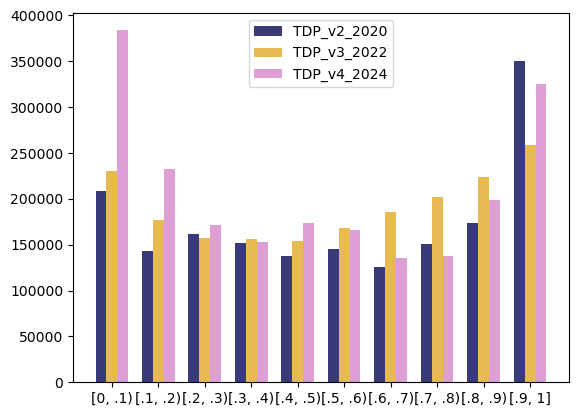

In [ ]:
v4_incl_prior_hist = pd.read_csv('v4_incl_prior_hist.csv')
# plt.hist(v4_incl_prior_hist['tdp_24_support_v4'], bins=10, rwidth =.9)
# plt.hist(v4_incl_prior_hist['tdp_22_support_v3'], bins=10, rwidth =.9)
# plt.hist(v4_incl_prior_hist['tdp_20_support_v2'], bins=10, rwidth =.9)

v4_2024 = v4_incl_prior_hist['tdp_24_support_v4']
v3_2022 = v4_incl_prior_hist['tdp_22_support_v3']
v2_2020 = v4_incl_prior_hist['tdp_20_support_v2']

cmap = plt.get_cmap('tab20b', 3)
plt.hist([ v2_2020, v3_2022, v4_2024], bins = 10, label=['TDP_v2_2020', 'TDP_v3_2022', 'TDP_v4_2024'], color=[cmap(i) for i in range(3)], align= 'left', rwidth= 0.7)
plt.xticks(np.arange(0, 1, 0.1), labels= ['[0, .1)', '[.1, .2)', '[.2, .3)', '[.3, .4)', '[.4, .5)', '[.5, .6)', '[.6, .7)', '[.7, .8)', '[.8, .9)', '[.9, 1]'])
plt.legend(loc='upper center')

In [29]:
QUERY_v4_incl_prior_models = """CREATE OR REPLACE TABLE `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist` AS 
SELECT  
DISTINCT v4.myv_van_id, 
hist.demographic_group, 

ROUND(v4.mon4rch_support/100, 4) AS tdp_24_support_v4,         #Sep 2024
scores24.dnc_2024_dem_party_support_v0 AS dnc_24_support,
scores24.turnout_2024_v2, 
scores24.clarity_2024_turnout_v3 AS clarity_24_turnout, 
hist.vote_g_2024, 
p24.state_house_district_latest AS hd_24, 
p24.van_precinct_id AS precinct_24,
hist.age_in_24, 

ROUND(v3.tdp_partisanship_score/100, 4) AS tdp_22_support_v3,  #Feb 2022
scores22.dnc_2022_dem_party_support AS dnc_22_support,
scores22.deck_2022_state_house_support,
scores22.clarity_2022_turnout AS clarity_22_turnout, 
hist.vote_g_2022, 
p22.state_house_district_latest AS hd_22, 
p22.van_precinct_id AS precinct_22_van,
p22.dnc_precinct_id AS precinct_22_dnc,
hist.age_in_22, 

ROUND(v2.tdp_partisanship_score/100, 4) AS tdp_20_support_v2,  #Sep 2020
scores20.dnc_2020_dem_party_support_v2 AS dnc_20_support_v2,
-- scores20.dnc_2020_dem_party_support AS dnc_20_support, (commented out because this is same as v2)

ROUND(v1.tdp_partisanship_score/100, 4) AS tdp_20_support_v1,  #Feb 2020
scores20.dnc_2020_dem_party_support_v1 AS dnc_20_support_v1,

scores20.clarity_2020_turnout AS clarity_20_turnout, 
hist.vote_g_2020, 
p20.state_house_district_latest AS hd_20, 
p20.van_precinct_id AS precinct_20_van,
p20.dnc_precinct_id AS precinct_20_dnc,
hist.age_in_20, 

FROM `demstxsp.mon4rch_2024.mon4rch` AS v4 
LEFT JOIN `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score` AS v3 ON v4.myv_van_id = v3.myv_van_id
LEFT JOIN `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v2` AS v2 ON v4.myv_van_id = v2.myv_van_id
LEFT JOIN `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v1` AS v1 ON v4.myv_van_id = v1.myv_van_id
LEFT JOIN `democrats.analytics_tx.person` AS p24 ON v4.myv_van_id = p24.myv_van_id
LEFT JOIN `democrats.analytics_archive_tx.person_2022` AS p22 ON p24.person_id = p22.person_id
LEFT JOIN `democrats.analytics_archive_tx.person_2020` AS p20 ON p24.person_id = p20.person_id
LEFT JOIN `demstxsp.reporting.post_election_analysis_coalitions_voting_history_96_thru_24` AS hist ON hist.person_id = p24.person_id
LEFT JOIN `democrats.scores_tx.all_scores_2024` AS scores24 ON scores24.person_id = p24.person_id
LEFT JOIN `democrats.scores_tx.all_scores_2022` AS scores22 ON scores22.person_id = p22.person_id
LEFT JOIN `democrats.scores_tx.all_scores_2020` AS scores20 ON scores20.person_id = p20.person_id
"""

In [30]:
QUERY_target_hd_history = """
CREATE OR REPLACE TABLE `demstxsp.tdp_partisanship_modeling.target_hd_history` AS 
WITH model_24 AS (
SELECT    
  CAST(LTRIM(hd_24 ,'0')AS INT64) AS HD, 
  ROUND(SUM(tdp_24_support_v4)) AS tdp_24_est_D_votes, 
  ROUND(SUM(dnc_24_support)) AS dnc_24_est_D_votes, 
FROM `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist`
WHERE vote_g_2024 = 1 AND hd_24 IN ('034','052', '054', '070', '074', '094', '096', '112', '118', '121', '138')
GROUP BY hd_24
), 

results_24 AS (
SELECT
  district AS HD,
  D AS act_24_D_votes,
  R AS R_votes_24, 
  L AS L_votes_24, 
  G AS G_votes_24, 
  Other AS W_votes_24, 
FROM `demstxsp.reporting.2024_general_districts_results`
WHERE 
  district_type = 'HD'
  AND CAST(district AS STRING) IN ('34','52', '54', '70', '74', '94', '96', '112', '118', '121', '138')
),

model_22 as (
SELECT    
  CAST(LTRIM(hd_22 ,'0')AS INT64) AS HD, 
  ROUND(SUM(tdp_22_support_v3)) AS tdp_22_est_D_votes, 
  ROUND(SUM(dnc_22_support)) AS dnc_22_est_D_votes, 
FROM `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist`
WHERE vote_g_2022= 1 AND hd_22 IN ('034','052', '054', '070', '074', '094', '096', '112', '118', '121', '138')
GROUP BY hd_22
), 

results_22 AS (
SELECT
  CAST(race_number AS INT64) AS HD,
  SUM(D_votes) AS act_22_D_votes,  
FROM `demstxsp.historical_vtd_2022G.2022_state_house` AS hd22
WHERE race_number IN ('34','52', '54', '70', '74', '94', '96', '112', '118', '121', '138')
GROUP BY race_number
), 

model_20 AS (
SELECT  
  CAST(LTRIM(hd_20 ,'0')AS INT64) AS HD, 
  ROUND(SUM(tdp_20_support_v2)) AS tdp_20_est_D_votes, 
  ROUND(SUM(dnc_20_support_v2)) AS dnc_20_est_D_votes, 
FROM `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist` AS v1
WHERE vote_g_2020 = 1  
  AND hd_20 IN ('034','052', '054', '070', '074', '094', '096', '112', '118', '121', '138')
GROUP BY hd_20
), 

results_20 AS (
SELECT
  CAST(race_number AS INT64) AS HD,
  SUM(D_votes) AS act_20_D_votes,  
FROM `demstxsp.historical_vtd_2022G.2020_state_house` AS hd20
WHERE race_number IN ('34','52', '54', '70', '74', '94', '96', '112', '118', '121', '138')
GROUP BY race_number
)

SELECT DISTINCT
model_24.HD, 
act_24_D_votes,
tdp_24_est_D_votes, 
dnc_24_est_D_votes, 
act_22_D_votes, 
tdp_22_est_D_votes, 
dnc_22_est_D_votes,
act_20_D_votes,  
tdp_20_est_D_votes, 
dnc_20_est_D_votes, 
FROM model_24 
LEFT JOIN results_24 ON model_24.HD = results_24.HD
LEFT JOIN model_22 ON model_24.HD = model_22.HD
LEFT JOIN results_22 ON model_22.HD = results_22.HD
LEFT JOIN model_20 ON model_24.HD = model_20.HD 
LEFT JOIN results_20 ON model_20.HD = results_20.HD
ORDER BY HD ASC
"""

In [31]:
QUERY_model_comparisons_target_hd_2024 = """
CREATE OR REPLACE TABLE `demstxsp.mon4rch_2024.model_comparisons_target_hd_2024` AS 
WITH actual_dem_votes AS (
SELECT 
HD, 
year, 
act_D_votes
FROM `demstxsp.tdp_partisanship_modeling.target_hd_history`
UNPIVOT (
  act_D_votes FOR year IN (
    act_20_D_votes AS '2020', act_22_D_votes AS '2022', act_24_D_votes AS '2024'))
), 

tdp_est_votes AS (
SELECT 
HD, 
year, 
tdp_est_D_votes
FROM `demstxsp.tdp_partisanship_modeling.target_hd_history`
UNPIVOT (
  tdp_est_D_votes FOR year IN (
    tdp_20_est_D_votes AS '2020', tdp_22_est_D_votes AS '2022', tdp_24_est_D_votes AS '2024'))
), 

dnc_est_votes AS (
SELECT 
HD, 
year, 
dnc_est_D_votes
FROM `demstxsp.tdp_partisanship_modeling.target_hd_history`
UNPIVOT (
  dnc_est_D_votes FOR year IN (
    dnc_20_est_D_votes AS '2020', dnc_22_est_D_votes AS '2022', dnc_24_est_D_votes AS '2024'))
)

SELECT 
act.*, 
tdp_est_D_votes, 
dnc_est_D_votes, 
ABS((act_D_votes-tdp_est_D_votes)/act_D_votes)*100 AS percent_error_tdp, 
ABS((act_D_votes-dnc_est_D_votes)/act_D_votes)*100 AS percent_error_dnc
FROM actual_dem_votes AS act
LEFT JOIN tdp_est_votes AS tdp ON (act.HD = tdp.HD AND act.year = tdp.year)
LEFT JOIN dnc_est_votes AS dnc ON (act.HD = dnc.HD AND act.year = dnc.year)
ORDER BY HD, year ASC
"""

In [3]:
model_comparisons = pd.read_csv('model_comparisons_target_hd_2024_MOST_RECENT.csv')

## Accuracy, Precision, Recall (DNC vs Mon4rch)

In [4]:
v2_results = pd.read_csv("2020 HD D votes (model estimates v actual).csv")
v3_results = pd.read_csv("2022 HD D votes (model estimates v actual).csv")
v2_results['pct_error_tdp'] = (v2_results['tdp_20_est_D_votes'] - v2_results['act_20_D_votes'])/(v2_results['act_20_D_votes'])*100
v2_results['pct_error_dnc'] = (v2_results['dnc_20_est_D_votes'] - v2_results['act_20_D_votes'])/(v2_results['act_20_D_votes'])*100

v3_results['pct_error_tdp']  = (v3_results['tdp_22_est_D_votes'] - v3_results['act_22_D_votes'])/(v3_results['act_22_D_votes'])*100
v3_results['pct_error_dnc']  = (v3_results['dnc_22_est_D_votes'] - v3_results['act_22_D_votes'])/(v3_results['act_22_D_votes'])*100 
v2_results = v2_results.rename(columns={'HD_2020': 'HD', 'precinct_2020': 'precinct'})
v3_results = v3_results.rename(columns={'HD_2022': 'HD', 'precinct_2022': 'precinct'})


In [5]:
v2_v3_diff = pd.merge(v2_results, v3_results, how = 'left', on = ['HD', 'precinct'],  suffixes=('_20', '_22'))

In [ ]:
plt.boxplot(v2_v3_diff['HD'], v2_v3_diff[''])
plt.errorbar(v2_v3_diff)

In [6]:
hd_precincts = pd.read_json( 'hd precincts.json' )
hd_precincts_2 = pd.read_json( 'hd precincts 2.json' )

hd_precincts = pd.concat([hd_precincts, hd_precincts_2])
hd_precincts['geography'] = hd_precincts['geography'].apply(wkt.loads)
hd_precincts = hd_precincts.dropna()
# hd_precincts = hd_precincts[hd_precincts['geography'].apply(lambda x: isinstance(x, str))]
hd_precincts = hd_precincts.rename(columns={'state_house_district': 'HD', 'van_precinct_id': 'precinct'})
hd_precincts = pd.merge(v2_v3_diff, hd_precincts, how = 'left', on = ['HD', 'precinct'])

c:\Users\shali\.conda\envs\tf-gpu-cuda9\lib\site-packages\geopandas\plotting.py:633: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


<AxesSubplot:>

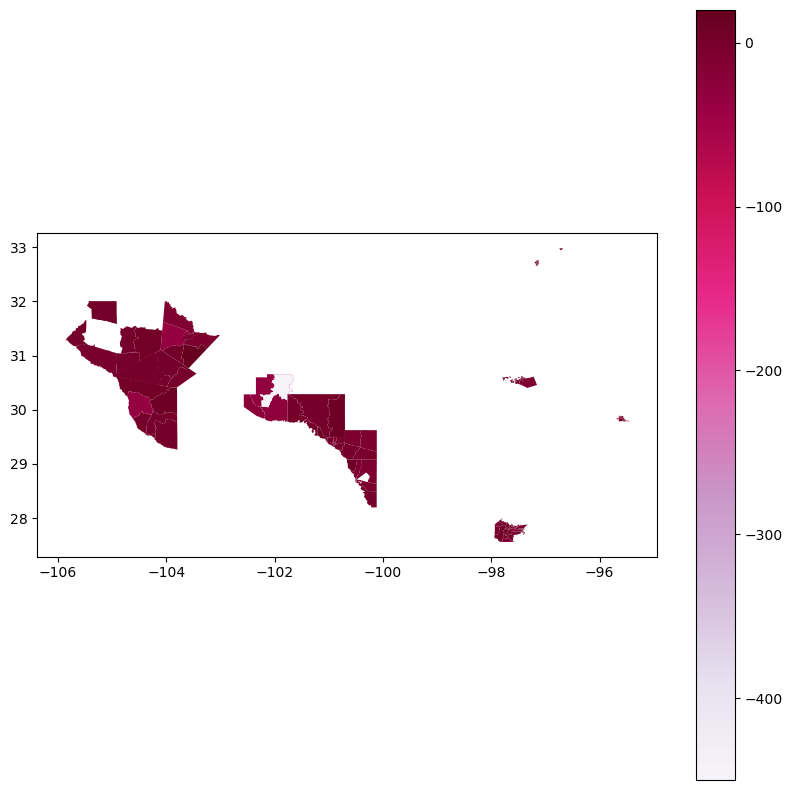

In [7]:
hd_precincts_geo = gpd.GeoDataFrame(hd_precincts, geometry='geography')

hd_precincts_geo['v2_v3_diff'] = (hd_precincts_geo['pct_error_tdp_22'] - hd_precincts_geo['pct_error_dnc_22'])
hd_precincts_geo.plot(figsize= (10, 10), column = 'v2_v3_diff', k = 10, colormap = 'PuRd', legend = True)

## Binned Scores by District

In [ ]:
v4_incl_prior_hist['v4_bin'] = pd.qcut(v4_incl_prior_hist['tdp_24_support_v4'], q = [0,0.1,.2, .3, .4, .5, .6, .7, .8, .9, 1])
categories = v4_incl_prior_hist['v4_bin'].value_counts().index
counts = v4_incl_prior_hist['v4_bin'].value_counts().values
plt.bar(categories, counts)

In [10]:
hd34 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 34]
# hd34 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 34]
# hd34 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 34]

hd52 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 52]
# hd52 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 52]
# hd52 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 52]

hd54 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 54]
# hd54 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 54]
# hd54 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 54]

hd70 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 70]
# hd70 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 70]
# hd70 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 70]

hd74 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 74]
# hd74 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 74]
# hd74 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 74]

hd94 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 94]
# hd94 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 94]
# hd94 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 94]

hd96 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 96]
# hd96 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 96]
# hd96 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 96]

hd112 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 112]
# hd112 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 112]
# hd112 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 112]

hd118 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 118]
# hd118 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 118]
# hd118 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 118]

hd121 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 121]
# hd121 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 121]
# hd121 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 121]

hd138 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_24']== 138]
# hd138 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_22']== 138]
# hd138 = v4_incl_prior_hist.loc[v4_incl_prior_hist['hd_20']== 138]

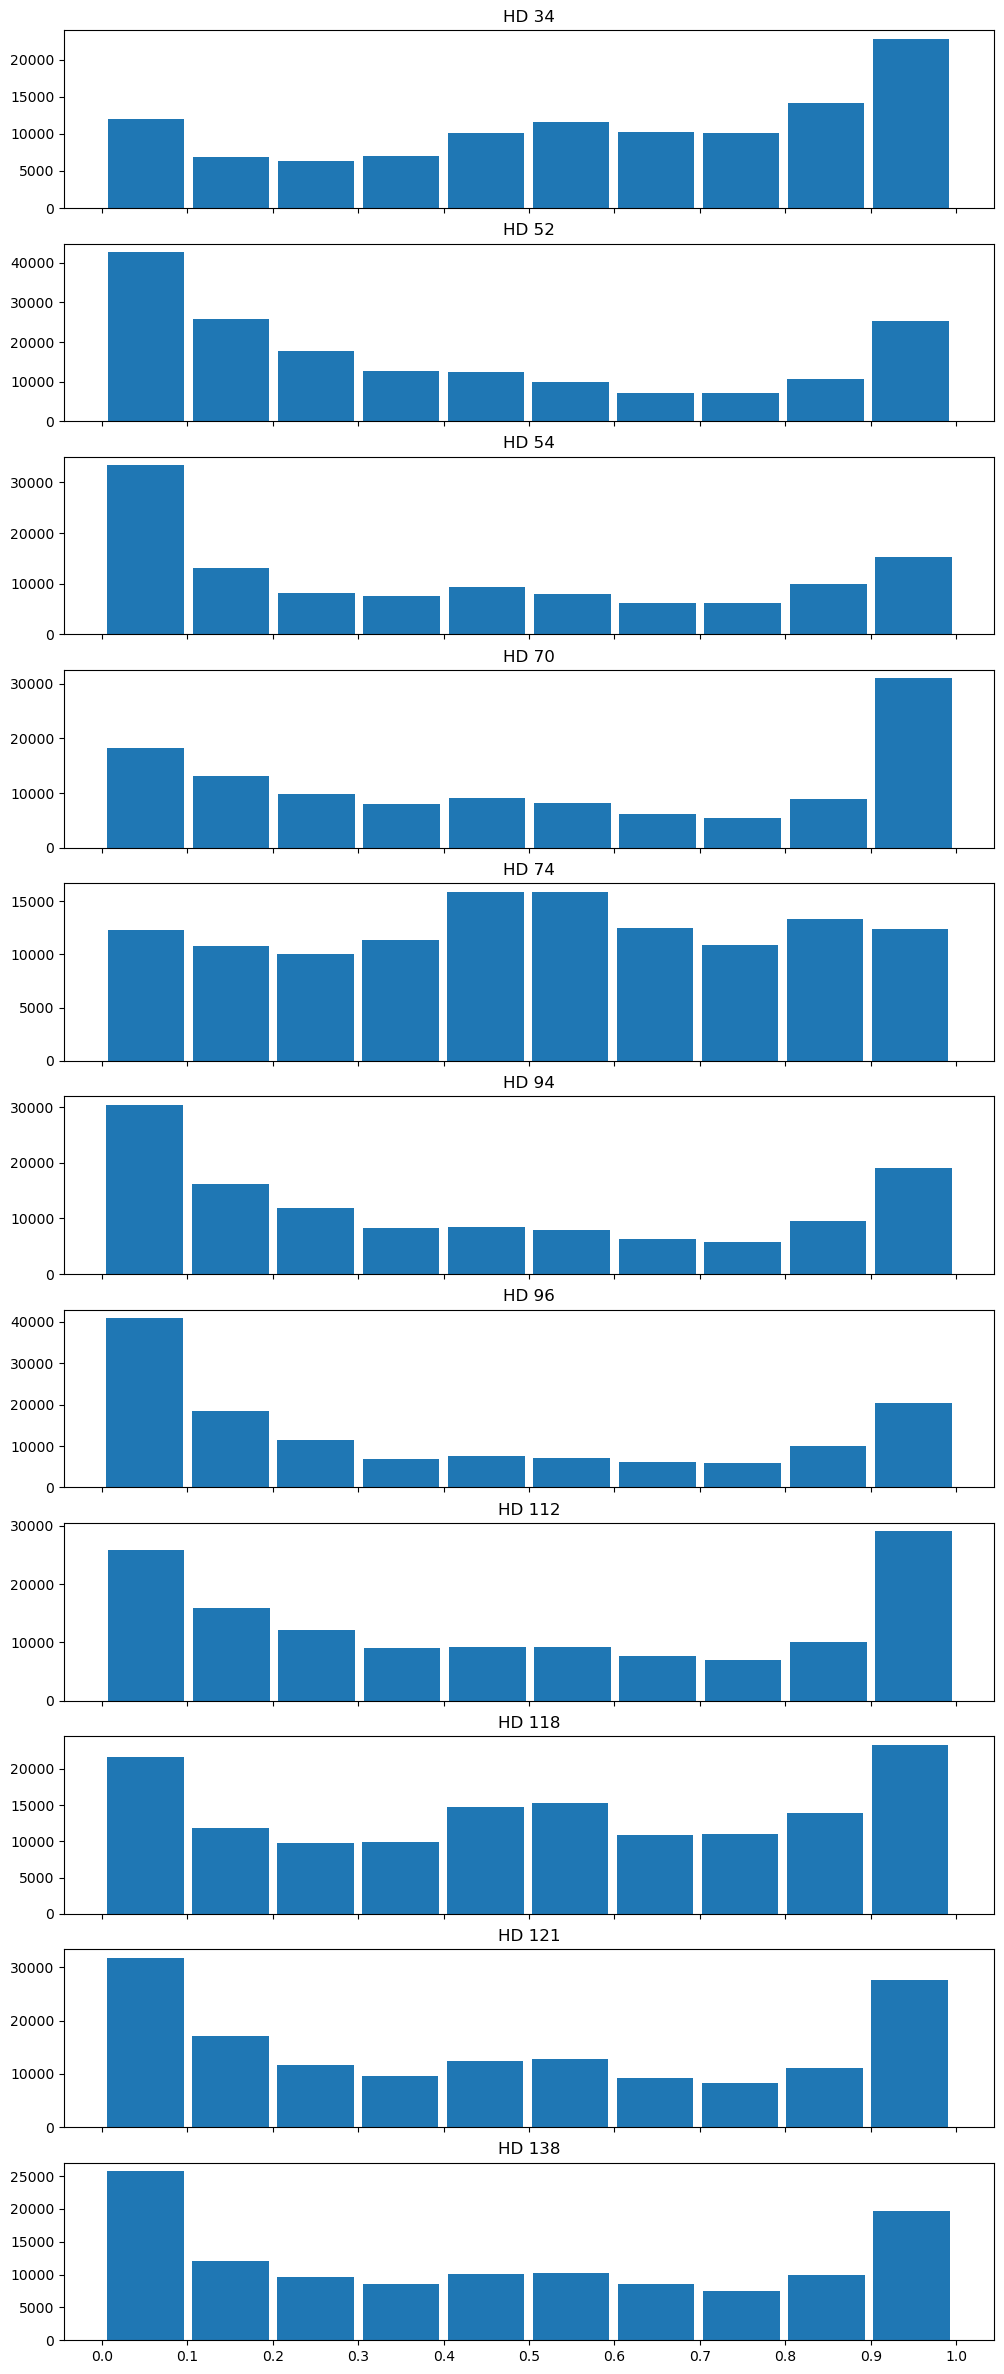

In [ ]:
fig, axs = plt.subplots(11, sharex=True, figsize=(12, 30))
axs[0].hist(hd34['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[0].set_title('HD 34')
axs[1].hist(hd52['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[1].set_title('HD 52')
axs[2].hist(hd54['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[2].set_title('HD 54')

axs[3].hist(hd70['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[3].set_title('HD 70')
axs[4].hist(hd74['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[4].set_title('HD 74')

axs[5].hist(hd94['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[5].set_title('HD 94')
axs[6].hist(hd96['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[6].set_title('HD 96')

axs[7].hist(hd112['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[7].set_title('HD 112')
axs[8].hist(hd118['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[8].set_title('HD 118')

axs[9].hist(hd121['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[9].set_title('HD 121')
axs[10].hist(hd138['tdp_24_support_v4'], bins=10, rwidth=0.9)
axs[10].set_title('HD 138')
axs[10].set_xticks(np.arange(0, 1.1, 0.1))


## Earlier TDP Partisanship Model Comparisons

### Distribution of V4, V3 & V2 Score Differences

In [ ]:
QUERY_redistricted_check = """
SELECT 
DISTINCT (p24.person_id), 
p24.state_house_district_latest AS hd_24, 
p24.van_precinct_id AS precinct_24,
p22.state_house_district_latest AS hd_22, 
p22.van_precinct_id AS precinct_22,
p20.state_house_district_latest AS hd_20, 
p20.van_precinct_id AS precinct_20, 
FROM `democrats.analytics_tx.person` AS p24
LEFT JOIN `democrats.analytics_archive_tx.person_2022` AS p22 ON p24.person_id = p22.person_id
LEFT JOIN `democrats.analytics_archive_tx.person_2020` AS p20 ON p24.person_id = p20.person_id
WHERE 
  p24.state_house_district_latest != p22.state_house_district_latest
  OR p24.state_house_district_latest != p20.state_house_district_latest 
  OR p22.state_house_district_latest != p20.state_house_district_latest
""" 

In [ ]:
QUERY_2022_models = """
WITH models_est_2022 AS (
SELECT    
  CAST(LTRIM(hd_22 ,'0') AS INT64) AS HD, 
  precinct_22_van AS van_precinct_id, 
  ROUND(SUM(tdp_22_support_v3)) AS tdp_22_est_D_votes, 
  ROUND(SUM(dnc_22_support)) AS dnc_22_est_D_votes, 
FROM `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist`
WHERE vote_g_2022= 1 AND hd_22 IN ('034','052', '054', '070', '074', '094', '096', '112', '118', '121', '138')
GROUP BY hd_22, precinct_22_van
), 

results_2022 AS (
SELECT
  CAST(race_number AS INT64) AS HD,
  p22.van_precinct_id,
  D_votes AS act_22_D_votes,  
  R_votes AS R_votes_22,  
  L_votes AS L_votes_22,  
  G_votes AS G_votes_22,  
  W_votes AS W_votes_22,  
FROM `demstxsp.historical_vtd_2022G.2022_state_house` AS hd22
LEFT JOIN `democrats.analytics_archive_tx.person_2022` AS p22 ON hd22.van_precinct_name = p22.van_precinct_name AND hd22.county_fips = p22.county_fips
WHERE race_number IN ('34','52', '54', '70', '74', '94', '96', '112', '118', '121', '138')
)

SELECT DISTINCT
model_est.HD AS HD_2022, 
model_est.van_precinct_id AS precinct_2022, 
act_22_D_votes, 
tdp_22_est_D_votes, 
dnc_22_est_D_votes, 
FROM models_est_2022 AS model_est
LEFT JOIN results_2022 AS results ON model_est.HD = results.HD AND model_est.van_precinct_id = results.van_precinct_id
ORDER BY HD_2022, precinct_2022 ASC
"""

In [ ]:
QUERY_2020_models = """
WITH models_est_2020 AS (
SELECT    
  CAST(LTRIM(hd_20 ,'0') AS INT64) AS HD, 
  precinct_20_van AS van_precinct_id, 
  ROUND(SUM(tdp_20_support_v1)) AS tdp_20_est_D_votes, 
  ROUND(SUM(dnc_20_support_v1)) AS dnc_20_est_D_votes, 
FROM `demstxsp.tdp_partisanship_modeling.tdp_tx_partisanship_score_v4_incl_prior_hist`
WHERE vote_g_2020= 1 AND hd_20 IN ('034','052', '054', '070', '074', '094', '096', '112', '118', '121', '138')
GROUP BY hd_20, precinct_20_van
), 

results_2020 AS (
SELECT
  CAST(race_number AS INT64) AS HD,
  p20.van_precinct_id,
  D_votes AS act_20_D_votes,  
  R_votes AS R_votes_20,  
  L_votes AS L_votes_20,  
  G_votes AS G_votes_20,  
  W_votes AS W_votes_20,  
FROM `demstxsp.historical_vtd_2022G.2020_state_house` AS hd20
LEFT JOIN `democrats.analytics_archive_tx.person_2020` AS p20 ON hd20.van_precinct_name = p20.van_precinct_name AND hd20.county_name = p20.county_name
WHERE race_number IN ('34','52', '54', '70', '74', '94', '96', '112', '118', '121', '138')
)

SELECT DISTINCT
model_est.HD AS HD_2020, 
model_est.van_precinct_id AS precinct_2020, 
act_20_D_votes, 
tdp_20_est_D_votes, 
dnc_20_est_D_votes, 
FROM models_est_2020 AS model_est
LEFT JOIN results_2020 AS results ON model_est.HD = results.HD AND model_est.van_precinct_id = results.van_precinct_id
ORDER BY HD_2020, precinct_2020 ASC
"""

### Grouped Bar Chart of TDP-DNC Support Model Point Difference by Year and HD

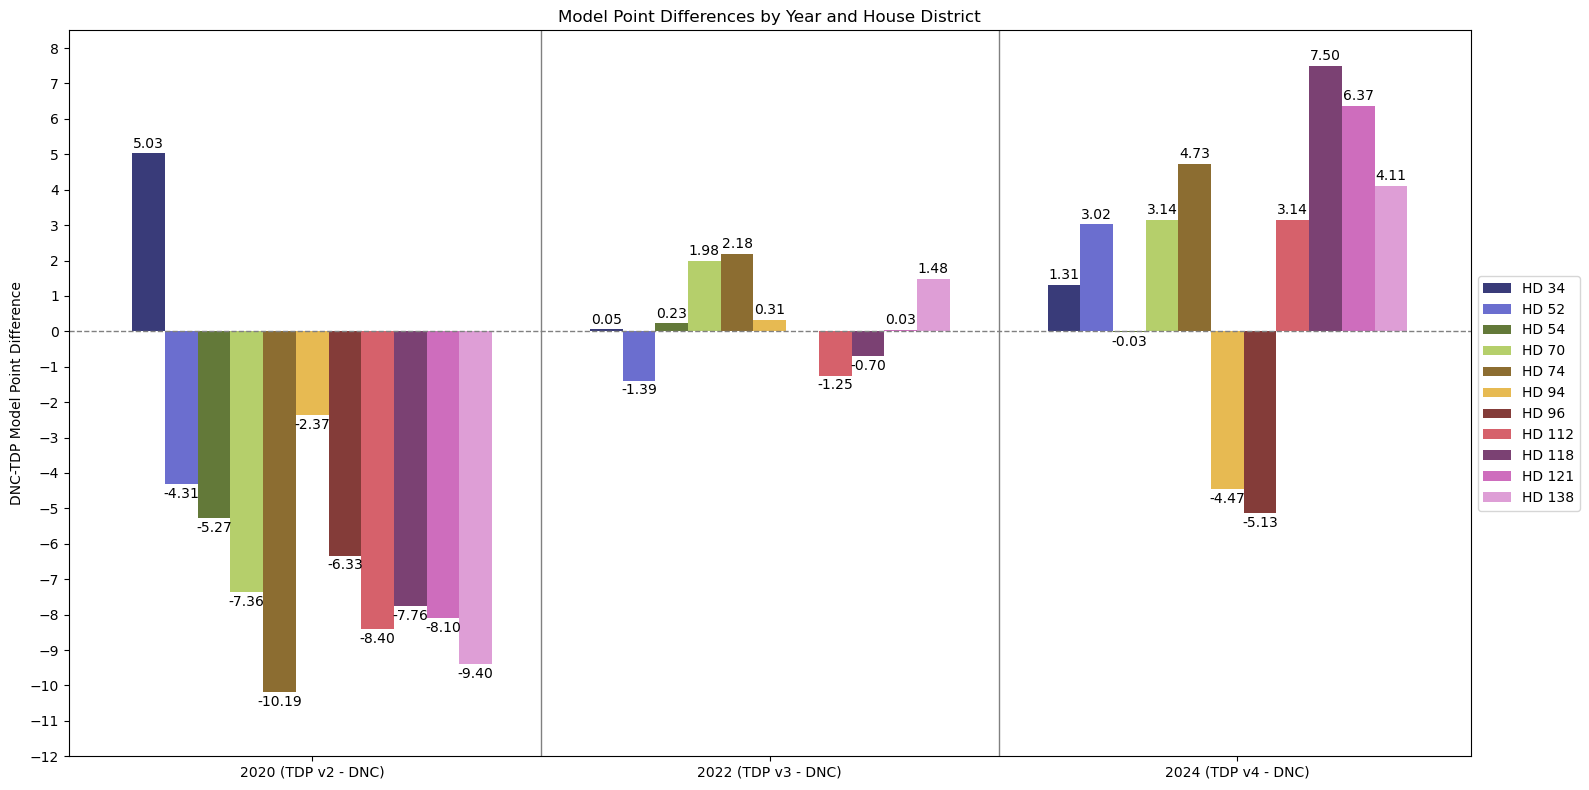

In [92]:
years = [2020, 2022, 2024]
hd_point_diff = {}
for hd in model_comparisons['HD'].unique():
    measurements = model_comparisons.loc[model_comparisons['HD'] == hd, ['year', 'point_difference']]
    measurements_dict = dict(zip(measurements['year'], measurements['point_difference']))
    hd_point_diff[f'HD {hd}'] = [measurements_dict.get(year, np.nan) for year in years]
hd_point_diff_df = pd.DataFrame(hd_point_diff, index = years)

x = np.arange(len(years))  # the label locations
width = 0.1  # the width of the bars
padding = 0.4  # the padding between groups
multiplier = 0

cmap = cm.get_cmap('tab20b', len(hd_point_diff))
colors = [cmap(i) for i in range(len(hd_point_diff))]
fig, ax = plt.subplots(figsize=(16, 8))

for attribute, measurement in hd_point_diff.items():
    color = colors[multiplier]
    offset = width * multiplier + padding * (np.arange(len(years)) + multiplier // len(hd_point_diff))
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = color)
    ax.bar_label(rects, padding=2, fmt='%.2f')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Model Point Differences by Year and House District')
ax.set_xticks([0.5, 1.9, 3.33])  
ax.set_xticklabels(['2020 (TDP v2 - DNC)', '2022 (TDP v3 - DNC)', '2024 (TDP v4 - DNC)'])


ax.set_ylim(-12, 8.5)
ax.set_yticks(np.arange(-12, 8.5, 1))
ax.set_ylabel('DNC-TDP Model Point Difference')

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(1.2, color='gray', linestyle='-', linewidth=1)
ax.axvline(2.6, color='gray', linestyle='-', linewidth=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

## Coalition Shift Over Time Analysis

### HD Maps

In [ ]:
hd34 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 34]
hd52 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 52]
hd54 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 54]
hd70 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 70]
hd74 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 74]
hd94 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 94]
hd96 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 96]
hd112 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 112]
hd118 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 118]
hd121 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 121]
hd138 = v4_incl_prior_hist.loc[v4_incl_prior_hist['HD'] == 138]


KeyError: 'HD'

## Issue Importance

In [8]:
issues = pd.read_csv("hd_issues_priorities.csv")

In [ ]:
fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])
survey_response_name = issues['survey_response_name']

cmap = cm.get_cmap('tab20b', len(survey_response_name))
colors = [cmap(i) for i in range(len(hd_point_diff))]

tab20b = plt.color_sequences["tab20b"]
outer_colors = [tab20b[i] for i in [0, 4, 8]]
inner_colors = [tab20b[i] for i in [1, 2, 5, 6, 9, 10]]

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

## Control Group Analysis

In [ ]:
QUERY_control_effect_mon4rch = """
CREATE OR REPLACE TABLE `demstxsp.mon4rch_2024.mon4rch_hd_control` AS 
WITH full_df AS (
SELECT 
  person_id, 
  district, 
  voted, 
  positive_id, 
  contact_type_name, 
  result_name,
  control, 
  coordinated_target
FROM `demstxsp.mon4rch_2024.hd_contacts`
), 

control_voted AS (
SELECT 
  district, 
  (CASE WHEN control = 1 AND voted = 1 THEN COUNT(person_id) END) AS control_voted,
FROM full_df
GROUP BY district, control, voted
), 

control_no_vote AS (
SELECT 
  district, 
  (CASE WHEN control = 1 AND voted = 0 THEN COUNT(person_id) END) AS control_no_vote,
FROM full_df
GROUP BY district, control, voted
), 

no_control_voted AS (
SELECT 
  district, 
  (CASE WHEN control = 0 AND voted = 1 THEN COUNT(person_id) END) AS no_control_voted,
FROM full_df
GROUP BY district, control, voted
), 

no_control_no_vote AS (
SELECT 
  district, 
  (CASE WHEN control = 0 AND voted = 0 THEN COUNT(person_id) END) AS no_control_no_vote, 
FROM full_df
GROUP BY district, control, voted
),

hd_control AS (
SELECT 
cv.*, 
cnv.control_no_vote, 
ROUND((cv.control_voted/(cnv.control_no_vote + cv.control_voted))*100, 2)  AS pct_voted_control,
ncv.no_control_voted, 
ncnv.no_control_no_vote,
ROUND((ncv.no_control_voted/(ncnv.no_control_no_vote + ncv.no_control_voted))*100, 2) AS pct_voted_targeted,
FROM control_voted AS cv
LEFT JOIN control_no_vote AS cnv ON cv.district=cnv.district
LEFT JOIN no_control_voted AS ncv ON cv.district=ncv.district
LEFT JOIN no_control_no_vote AS ncnv ON cv.district=ncnv.district
WHERE 
cv.control_voted IS NOT NULL AND 
cnv.control_no_vote IS NOT NULL AND 
ncv.no_control_voted IS NOT NULL AND 
ncnv.no_control_no_vote IS NOT NULL
)

SELECT 
  *, 
  ROUND(pct_voted_targeted - pct_voted_control, 2) AS hd_control_turnout_deficit
FROM hd_control
ORDER BY hd_control_turnout_deficit ASC
"""

## Contact Attempt Analysis

In [15]:
contacts_control_data = pd.read_csv('hd_contacts_control_data.csv')

## Redistricting Analysis

In [17]:
v4_incl_prior_hist = pd.read_csv("complete HD redistrict + vote + score history.csv")

In [16]:
bexar_precinct_results_24 = pd.read_csv("SOS to VAN PrecinctID Conversion Table.csv")
bexar_precinct_results_24 = bexar_precinct_results_24.dropna(how='all')
bexar_precinct_results_24 = bexar_precinct_results_24.replace({'party': {'Kristian Carranza': "D", 'Laurel Jordan Swift' : "D", 'Marc LaHood' : 'R', 'John Lujan III': 'R'}})
bexar_precinct_results_24['party'] = np.where(bexar_precinct_results_24['party'].isin(['D', 'R']), bexar_precinct_results_24['party'], None)
# Replace gaps forward from the previous valid value in: 'sos_precinct_id'
bexar_precinct_results_24 = bexar_precinct_results_24.fillna({'sos_precinct_id': bexar_precinct_results_24['sos_precinct_id'].ffill()})

# Replace gaps forward from the previous valid value in: 'HD'
bexar_precinct_results_24 = bexar_precinct_results_24.fillna({'HD': bexar_precinct_results_24['HD'].ffill()})

# Drop rows with missing data in column: 'party'
bexar_precinct_results_24 = bexar_precinct_results_24.dropna(subset=['party'], how='all')
bexar_precinct_results_24[['total', 'early']] = bexar_precinct_results_24[['total', 'early']].apply(pd.to_numeric)
bexar_precinct_results_24 = bexar_precinct_results_24.pivot_table(index = ['sos_precinct_id', 'HD'], columns= 'party', values = ['total', 'eday', 'mail', 'early'])
bexar_precinct_results_24.columns = [f"{col[1]}_{col[0]}" for col in bexar_precinct_results_24.columns]
bexar_precinct_results_24 = bexar_precinct_results_24.reset_index(drop=False)